**Author**: Andy Tzanidakis \
**Last updated**: May 9, 2024

## Overview

In this notebook we will learn how to use the outputs from LSDB catalogs and use `ensamble` from TAPE to compute time-series features.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
%matplotlib inline
import numpy as np
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')


import lsdb
import dask

# Configurations for dask
dask.config.set({"temporary-directory" :'/epyc/ssd/users/atzanida/tmp'})
dask.config.set({"dataframe.shuffle-compression": 'Snappy'})

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/config.py:789: FutureWarning: Dask configuration key 'dataframe.shuffle-compression' has been deprecated; please use 'dataframe.shuffle.compression' instead
  warnings.warn(


## Initialize hipscat catalogs

In [3]:
%%time
gaia = lsdb.read_hipscat("/data3/epyc/data3/hipscat/catalogs/gaia_dr3/gaia")

# load ZTF object table
ztf = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14")

# Load ZTF DR14 zources
ztf_sources = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_zource")

CPU times: user 1.68 s, sys: 92.7 ms, total: 1.78 s
Wall time: 1.82 s


## Cone Search 

In [4]:
%%time

# Cone search around a given position
ra, dec = 132.8460000, +11.8140000
rad = 5_000  # in arcsec

_sample = ztf.cone_search(ra=ra,
    dec=dec,
    radius_arcsec=rad).crossmatch(gaia, radius_arcsec=3, require_right_margin=False).compute()

/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/dask/crossmatch_catalog_data.py:117: RuntimeWarning: Right catalog does not have a margin cache. Results may be inaccurate
  warnings.warn("Right catalog does not have a margin cache. Results may be inaccurate", RuntimeWarning)


CPU times: user 6.54 s, sys: 9.28 s, total: 15.8 s
Wall time: 5.52 s


In [5]:
print (f"Number of objects in crossmatch: {len(_sample)}")

Number of objects in crossmatch: 36717


In [6]:
_sample.head(1)

,ps1_objid_ztf_dr14,ra_ztf_dr14,dec_ztf_dr14,ps1_gMeanPSFMag_ztf_dr14,ps1_rMeanPSFMag_ztf_dr14,ps1_iMeanPSFMag_ztf_dr14,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,mean_mag_g_ztf_dr14,...,ag_gspphot_lower_gaia,ag_gspphot_upper_gaia,ebpminrp_gspphot_gaia,ebpminrp_gspphot_lower_gaia,ebpminrp_gspphot_upper_gaia,libname_gspphot_gaia,Norder_gaia,Dir_gaia,Npix_gaia,_dist_arcsec
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
1195635224533270528,120581332336983267,133.2337,10.485653,21.3888,20.348801,19.2001,25,439,31,21.320099,...,NaN,NaN,NaN,NaN,NaN,<NA>,3,0,66,0.085933


In [7]:
%%time
# Convert crossmatch _sample to lsdb Catalog object
_sample_hips = lsdb.from_dataframe(
    _sample, 
    ra_column="ra_ztf_dr14", 
    dec_column="dec_ztf_dr14", 
    lowest_order=5
)

In [7]:
_sample_hips

,ps1_objid_ztf_dr14,ra_ztf_dr14,dec_ztf_dr14,ps1_gMeanPSFMag_ztf_dr14,ps1_rMeanPSFMag_ztf_dr14,ps1_iMeanPSFMag_ztf_dr14,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,mean_mag_g_ztf_dr14,mean_mag_r_ztf_dr14,mean_mag_i_ztf_dr14,Norder_ztf_dr14,Dir_ztf_dr14,Npix_ztf_dr14,ra_gaia,dec_gaia,parallax_gaia,parallax_over_error_gaia,bp_rp_gaia,solution_id_gaia,source_id_gaia,pmra_gaia,pmra_error_gaia,pmdec_gaia,pmdec_error_gaia,parallax_error_gaia,phot_g_mean_mag_gaia,l_gaia,b_gaia,non_single_star_gaia,classprob_dsc_combmod_galaxy_gaia,classprob_dsc_combmod_star_gaia,in_qso_candidates_gaia,_dist_arcsec,Norder,Dir,Npix
npartitions=2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1196831600973709312,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int32,int32,int32,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,bool,float64,uint8,uint64,uint64
1209216499948978176,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


### Join sample hips with ZTF sources 

In [42]:
ss = _sample_hips.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid")

/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/dask/join_catalog_data.py:195: RuntimeWarning: Right catalog does not have a margin cache. Results may be inaccurate
  warnings.warn("Right catalog does not have a margin cache. Results may be inaccurate", RuntimeWarning)


### Initialize Dask Client

In [9]:
from dask.distributed import Client
client = Client(n_workers=5, memory_limit="auto")

In [10]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 100,Total memory: 1.02 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36210,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 100
Started: Just now,Total memory: 1.02 TiB
Comm: tcp://127.0.0.1:45712,Total threads: 20
Dashboard: http://127.0.0.1:37068/status,Memory: 209.91 GiB
Nanny: tcp://127.0.0.1:38897,


## Initialize TAPE `ens`

In [43]:
import dask.dataframe as dd
from tape import Ensemble, ColumnMapper

# Initialize an Ensemble
ens = Ensemble(client=client)

In [44]:
ens.client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 100,Total memory: 1.02 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36210,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 100
Started: 1 hour ago,Total memory: 1.02 TiB
Comm: tcp://127.0.0.1:45712,Total threads: 20
Dashboard: http://127.0.0.1:37068/status,Memory: 209.91 GiB
Nanny: tcp://127.0.0.1:38897,


In [24]:
import tape as tape
tape.__version__

'0.4.1'

In [45]:
# ColumnMapper Establishes which table columns map to timeseries quantities
colmap = ColumnMapper(
        id_col='_hipscat_index',
        time_col='mjd',
        flux_col='mag',
        err_col='magerr',
        band_col='band',
      )

# Ens to LSDB catalogs
ens.from_lsdb(
    source_catalog=ss,
    object_catalog=_sample_hips,
    column_mapper=colmap,
    sync_tables=False,
    sorted=True,
    sort=True)

## Define Custom Time Series Function

In [46]:
from astropy.timeseries import LombScargle

def compute_optimized_periodogram_grid(x0, oversampling_factor=5, nyquist_factor=3):
    """
    Computes an optimized periodogram frequency grid for a given time series. 
    
    Implemented in https://github.com/astroML/gatspy/blob/71384b8d15531bc01a6b85250a35cd675edccf44/gatspy/periodic/modeler.py#L94

    Parameters:
    - x0 (array-like): The input time axis.
    - oversampling_factor (int, optional): The oversampling factor for frequency grid. Default is 5.
    - nyquist_factor (int, optional): The Nyquist factor for frequency grid. Default is 3.

    Returns:
    - array: The computed optimized periodogram frequency grid.
    """

    # Number of data points in the time series
    num_points = len(x0)

    # Calculate the baseline of the time series
    baseline = np.max(x0) - np.min(x0)

    # Calculate the frequency resolution based on oversampling factor and baseline
    frequency_resolution = 1. / baseline / oversampling_factor

    # Calculate the number of frequencies and the frequency grid
    num_frequencies = int(0.5 * oversampling_factor * nyquist_factor * num_points)
    frequencies = frequency_resolution + frequency_resolution * np.arange(num_frequencies)

    return frequencies


def calc_invNeumann(t, mag, wstd):
    """Calculate the time-weighted inverse Von Neumann stat.
        Source: https://github.com/ZwickyTransientFacility/scope/blob/5a67134ab2cf41d0aab2c1b8920f63a67b48362e/tools/featureGeneration/lcstats.py#L69
    """
    dt = t[1:] - t[:-1]
    dm = mag[1:] - mag[:-1]

    w = (dt) ** -2  # inverse deltat weighted
    eta = np.sum(w * dm**2)
    eta /= np.sum(w) * wstd**2

    return eta**-1


def calc_NormExcessVar(mag, err, N, wmean):
    """    Source: https://github.com/ZwickyTransientFacility/scope/blob/5a67134ab2cf41d0aab2c1b8920f63a67b48362e/tools/featureGeneration/lcstats.py#L69
    """
    stat = np.sum((mag - wmean) ** 2 - err**2)
    stat /= N * wmean**2
    return stat

def calc_features(time, mag, magerr, flag, band):
    """Calculate the skewness and kurtosis of a light curve for good detections in r-band."""

    rmv = (flag == 0) & (~np.isnan(flag)) &  (band=='r') & (~np.isnan(mag)) & (~np.isnan(magerr)) & (magerr < 99) & (mag < 99)
    rmvg = (flag == 0) & (~np.isnan(flag)) &  (band=='g') & (~np.isnan(mag)) & (~np.isnan(magerr)) & (magerr < 99) & (mag < 99)

    time_, mag_, magerr_ = time[rmv], mag[rmv], magerr[rmv]
    
    timeg, magg, magerrg = time[rmv], mag[rmv], magerr[rmv]
    
    if len(time_)>0:
        lsp = LombScargle(time_,
                          mag_,
                          magerr_,
                          fit_mean=True,
                          center_data=True,
                          nterms=1, 
                         normalization='standard')
        
        # Determine optimal frequency grid given data...
        f_grid = compute_optimized_periodogram_grid(time,
                                                    oversampling_factor=0.3, nyquist_factor=100)
        power = lsp.power(f_grid)
        period = 1/f_grid
        snr = (max(power)-np.mean(power))/np.std(power)
        
        # Other featues to compute 
        neu = calc_invNeumann(time_, mag_, np.nanstd(mag_))
        noe = calc_NormExcessVar(mag_, magerr_, len(mag_), np.nanstd(mag_))
        var = np.var(mag_)
        var_tar = np.var(mag_)**2
        Nsig = len(mag_[mag_ > np.nanmedian(mag_)])
        Nphot = len(time_)
        
        return period[np.argmax(power)], power[np.argmax(power)], snr, np.nanmean(mag), neu, noe, var, var_tar, Nsig, Nphot     
    else:
        return 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [48]:
res2 = ens.batch(
    calc_features, "mjd_ztf_zource", "mag_ztf_zource", 
    'magerr_ztf_zource', 
    'catflags_ztf_zource', 'band_ztf_zource', band_to_calc='r')

Using generated label, result_1, for a batch result.


In [49]:
%%time
table = res2.compute()

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 10.32 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/tmp/ipykernel_67774/4161147867.py:79: RuntimeWarning: invalid value encountered in scalar subtract
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/tmp/ipykernel_67774/4161147867.py:25: RuntimeWarning: divide by zero encountered in scalar divide
/tmp/ipykernel_67774/4161147867.py:29: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_67774/4161147867.py:43: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_67774/4161147867.py:52: RuntimeWarning: divide by zero encountered in scalar divide
/tmp/ipykernel_67774/4161147867.py:79: RuntimeWarnin

/tmp/ipykernel_67774/4161147867.py:79: RuntimeWarning: invalid value encountered in scalar subtract
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/tmp/ipykernel_67774/4161147867.py:43: RuntimeWarning: invalid value encountered in scalar divide
/tmp/ipykernel_67774/4161147867.py:52: RuntimeWarning: divide by zero encountered in scalar divide


CPU times: user 32.7 s, sys: 11.6 s, total: 44.3 s
Wall time: 4min 27s


In [50]:
table

,result
_hipscat_index,
1197102023665778688,"(0.9647162875816981, 0.4777762951222293, 5.792..."
1197103480121065472,"(0.06370653166338307, 0.034651001388064796, 7...."
1197103515705540608,"(3.5456659133858355, 0.03911102100271853, 7.16..."
1197103524685545472,"(0.9643667317596591, 0.20091344906386435, 7.28..."
1197103575080108032,"(0.15201430960376094, 0.03225828928262473, 8.3..."
...,...
1216398610040619008,"(0.999334668874175, 0.046332820096498854, 11.1..."
1216398648858902528,"(1.0195914527027057, 0.09011229902469053, 9.06..."
1216398683654848512,"(0.05561407960687963, 0.02856157475943304, 7.4..."


In [51]:
%%time
table[['period', 'power', 'snr', 'mu_mag', 
      'neu', 'noe', 'var', 'var_tar', 'Nsig', 'Nphot']] = pd.DataFrame(table['result'].tolist(), index=table.index)

CPU times: user 55.7 ms, sys: 8.53 ms, total: 64.3 ms
Wall time: 60 ms


In [52]:
table.drop(columns=['result'], inplace=True)

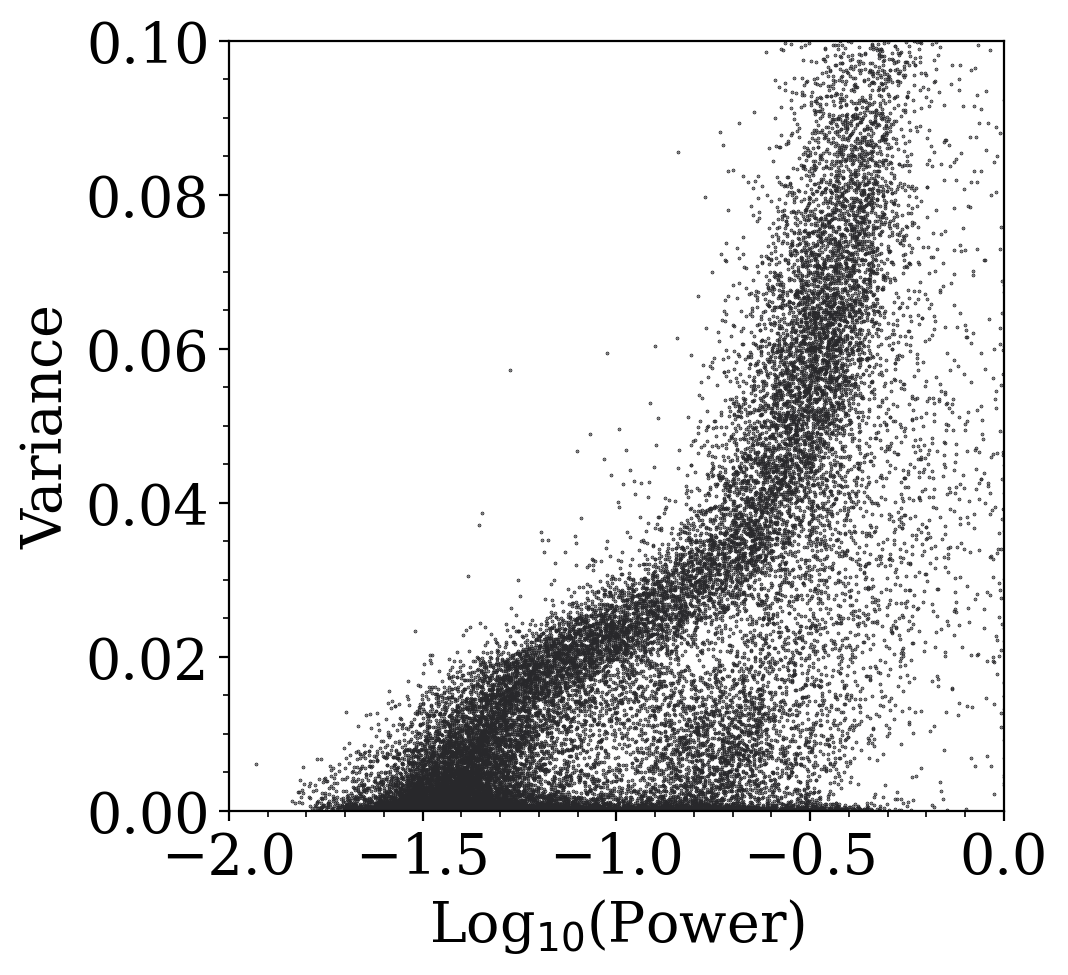

In [65]:
plt.figure(figsize=(5,5))
plt.scatter(np.log10(table['power']), table['var'], s=0.1, color="#28282B")
plt.ylim(0, 0.1)
plt.xlim(-2, 0)
plt.xlabel("Log$_{10}$(Power)")
plt.ylabel("Variance")
plt.minorticks_on()

## Plot Lightcurve